In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

In [2]:
train_targets = pd.read_parquet('./data/A/train_targets.parquet')
X_test_estimated = pd.read_parquet('./data/A/X_test_estimated.parquet')
X_train_estimated = pd.read_parquet('./data/A/X_train_estimated.parquet')
X_train_observed = pd.read_parquet('./data/A/X_train_observed.parquet')

In [3]:
df = pd.concat([X_train_observed, X_train_estimated])
df = pd.merge(df, train_targets, left_on='date_forecast', right_on='time', how='inner')
df = df.drop(columns=['date_calc', 'date_forecast'])
df = df.drop(columns=['elevation:m', 'snow_density:kgm3', 'snow_drift:idx'], axis=1)

imputer = SimpleImputer(strategy='mean')
df[['ceiling_height_agl:m', 'cloud_base_agl:m']] = imputer.fit_transform(df[['ceiling_height_agl:m', 'cloud_base_agl:m']])

X = df.drop(columns=['pv_measurement', 'time']) # Drop the index, target, and time columns
y = df['pv_measurement'] # Target variable

In [4]:
# Define the split date
split_date = '2022-10-27'

# Convert the 'time' column to a datetime object
df['time'] = pd.to_datetime(df['time'])

# Sorting the data by the 'time' column to maintain chronological order
df.sort_values('time', inplace=True)

# Splitting the data into training and test sets based on the split date
train_df = df[df['time'] < split_date]
test_df = df[df['time'] >= split_date]

# Identifying the features and the target variable
X_train = train_df.drop(columns=['pv_measurement', 'time'])  # Assuming all other columns are features
y_train = train_df['pv_measurement']
X_test = test_df.drop(columns=['pv_measurement', 'time'])
y_test = test_df['pv_measurement']

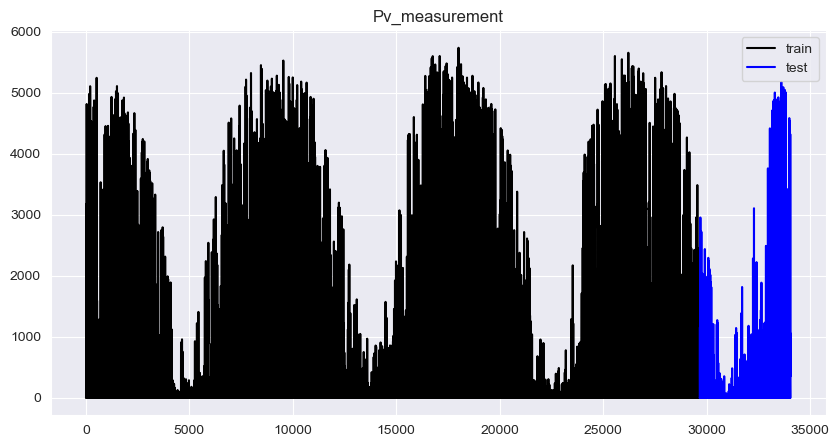

In [5]:
y_train.plot(style='k', figsize=(10, 5), label='train')
y_test.plot(style='b', figsize=(10, 5), label='test')

plt.title('Pv_measurement')
plt.legend()

# First Baseline Model: XGBoost

In [6]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)
y_pred = np.maximum(y_pred, 0)
# Calculate MAE on the test set
mae = mean_absolute_error(y_test, y_pred)
mae

131.37095773036935

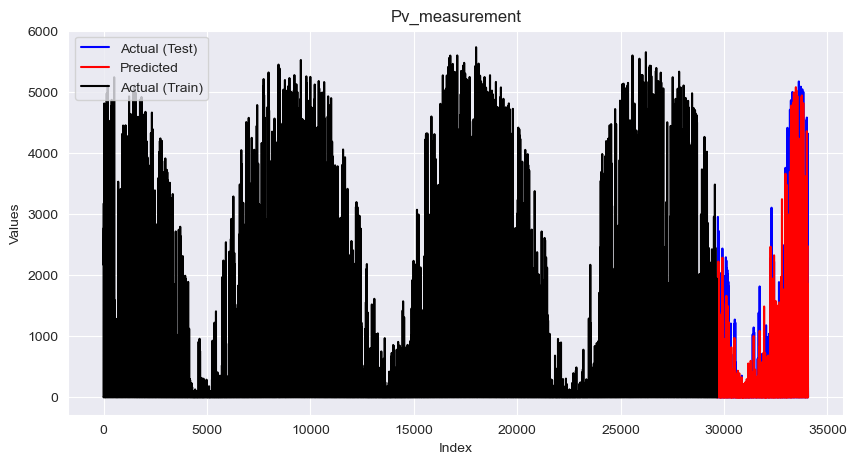

In [7]:
# Create a DataFrame to hold actual and predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Plot actual and predicted values
plt.figure(figsize=(10, 5))
plt.plot(results_df.index, results_df['Actual'], 'b', label='Actual (Test)')
plt.plot(results_df.index, results_df['Predicted'], 'r', label='Predicted')
plt.plot(y_train.index, y_train, 'k', label='Actual (Train)')
plt.title('Pv_measurement')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

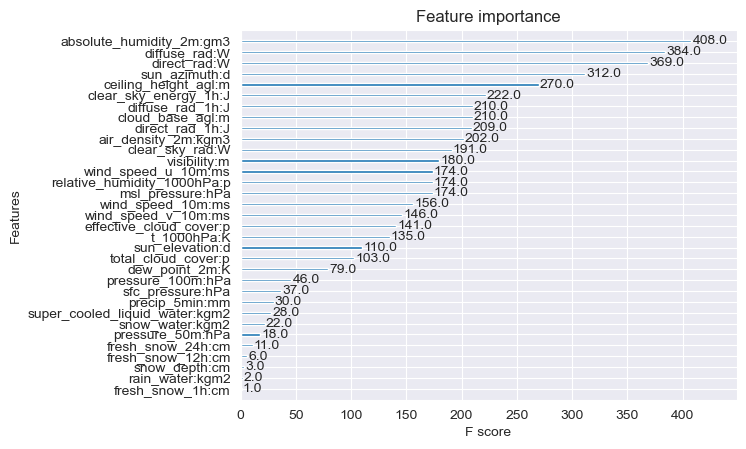

In [8]:
xgb.plot_importance(xgb_model)
plt.show()

In [9]:
def date_features(df):
    df['hour'] = pd.to_datetime(df['time']).dt.hour
    df['day'] = pd.to_datetime(df['time']).dt.dayofyear
    df['month'] = pd.to_datetime(df['time']).dt.month
    df['quarter'] = pd.to_datetime(df['time']).dt.quarter
    return df

df = date_features(df)

In [10]:
def is_estimated(df):
    split_date = '2022-10-27'
    df['is_estimated'] = 0  # Initialize with 0 (indicating observed)
    df.loc[df['time'] >= pd.Timestamp(split_date), 'is_estimated'] = 1  # Set 1 for estimated data
    return df

df = is_estimated(df)

In [11]:
# Define the split date
split_date = '2022-10-27'

# Convert the 'time' column to a datetime object
df['time'] = pd.to_datetime(df['time'])

# Sorting the data by the 'time' column to maintain chronological order
df.sort_values('time', inplace=True)

# Splitting the data into training and test sets based on the split date
train_df = df[df['time'] < split_date]
test_df = df[df['time'] >= split_date]

# Identifying the features and the target variable
X_train = train_df.drop(columns=['pv_measurement', 'time'])  # Assuming all other columns are features
y_train = train_df['pv_measurement']
X_test = test_df.drop(columns=['pv_measurement', 'time'])
y_test = test_df['pv_measurement']

In [12]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)
y_pred = np.maximum(y_pred, 0)
# Calculate MAE on the test set
mae = mean_absolute_error(y_test, y_pred)
mae

132.10905032139314

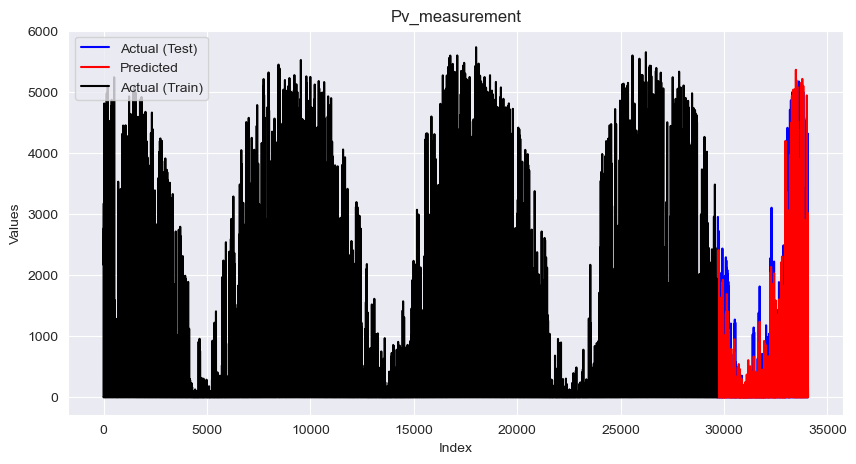

In [13]:
# Create a DataFrame to hold actual and predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Plot actual and predicted values
plt.figure(figsize=(10, 5))
plt.plot(results_df.index, results_df['Actual'], 'b', label='Actual (Test)')
plt.plot(results_df.index, results_df['Predicted'], 'r', label='Predicted')
plt.plot(y_train.index, y_train, 'k', label='Actual (Train)')
plt.title('Pv_measurement')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

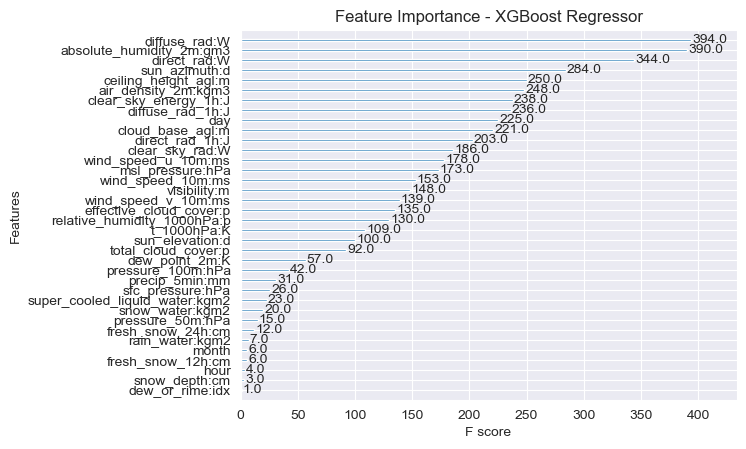

In [14]:
xgb.plot_importance(xgb_model, importance_type='weight')  # You can adjust 'max_num_features' as needed
plt.title("Feature Importance - XGBoost Regressor")
plt.show()

In [14]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Create the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Set up the grid search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Perform the grid search on the training data (assuming X_train_a and y_train_a are your training data)
grid_search.fit(X_train_a, y_train_a)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score

# E2E model to deliverable, simple optuna tuning
- Only using hourly data (not quarterly)
- no care taken to bad data in location B and C
    - other than filling with mean and dropping
- one model for all locations, location added as feature


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, make_scorer

import warnings
warnings.filterwarnings('ignore')


### Loading and reparing data

In [2]:
A_train_targets = pd.read_parquet('./data/A/train_targets.parquet')
A_X_train_estimated = pd.read_parquet('./data/A/X_train_estimated.parquet')
A_X_train_observed = pd.read_parquet('./data/A/X_train_observed.parquet')
A_X_test = pd.read_parquet('./data/A/X_test_estimated.parquet')

B_train_targets = pd.read_parquet('./data/B/train_targets.parquet')
B_X_train_estimated = pd.read_parquet('./data/B/X_train_estimated.parquet')
B_X_train_observed = pd.read_parquet('./data/B/X_train_observed.parquet')
B_X_test = pd.read_parquet('./data/B/X_test_estimated.parquet')

C_train_targets = pd.read_parquet('./data/B/train_targets.parquet')
C_X_train_estimated = pd.read_parquet('./data/B/X_train_estimated.parquet')
C_X_train_observed = pd.read_parquet('./data/B/X_train_observed.parquet')
C_X_test = pd.read_parquet('./data/B/X_test_estimated.parquet')

X_train_estimated = {
    'A': A_X_train_estimated,
    'B': B_X_train_estimated,
    'C': C_X_train_estimated,
}
X_train_observed = {
    'A': A_X_train_observed,
    'B': B_X_train_observed,
    'C': C_X_train_observed,
}
train_targets = {
    'A': A_train_targets,
    'B': B_train_targets,
    'C': C_train_targets,
}
X_test_submission = {
    'A': A_X_test,
    'B': B_X_test,
    'C': C_X_test,
}

preparation:
result is a single dictionary `train_set_merged` with the keys `A`, `B` and `C`, for each corresponding location. one new feature is added: `location`, and the prediction-target is added as a columns as well: `y`

In [3]:
# Marking each row with its location origin
for location in X_train_estimated.keys():
    X_train_estimated[location]['location'] = location
    X_train_observed[location]['location'] = location
    X_test_submission[location]['location'] = location
    X_train_estimated[location]['location'] = X_train_estimated[location]['location'].astype('category')
    X_train_observed[location]['location'] = X_train_observed[location]['location'].astype('category')
    X_test_submission[location]['location'] = X_test_submission[location]['location'].astype('category')

# Making a test set for each location
train_set_merged = {}
for location in X_train_estimated.keys():
    # concatinating observed and estimated
    concatinated = pd.concat(
        [X_train_observed[location], X_train_estimated[location]]
    )
    
    # merging target value into the training set
    merged = pd.merge(
        concatinated,
        train_targets[location],
        left_on='date_forecast',
        right_on='time',
        how='inner'
    )

    # dropping dates
    merged = merged.drop(columns=['date_calc', 'date_forecast'])

    # dropping some other shit
    merged = merged.drop(columns=['elevation:m', 'snow_density:kgm3', 'snow_drift:idx', 'direct_rad_1h:J', 'clear_sky_energy_1h:J', 'diffuse_rad_1h:J'], axis=1)

    # filling bad samples
    imputer = SimpleImputer(strategy='mean')
    merged[['ceiling_height_agl:m', 'cloud_base_agl:m']] = imputer.fit_transform(merged[['ceiling_height_agl:m', 'cloud_base_agl:m']])

    # remove bad values
    # merged['pv_measurement'].replace(0.0, np.nan, inplace=True)

    # # Remove rows with NaN values in the 'pv_measurement' column
    # merged.dropna(subset=['pv_measurement'], inplace=True)

    # Use the mask to filter both X_train and y_train

    # Filling rows with NaN values
    # Define the default fill value
    # Identify categorical columns
    categorical_columns = merged.select_dtypes(include='category').columns

    # Exclude categorical columns from the fill operation
    for col in merged.columns:
        if col not in categorical_columns:
            merged[col] = merged[col].fillna(merged[col].mean())


    train_set_merged[location] = merged



### Split into test-set and train-set

In [4]:
# split_date = '2022-12-27' # use this when locally testing
split_date = '2023-04-20' # use this when producing submitted file

X_train_dict = {}
y_train_dict = {}
X_test_dict = {}
y_test_dict = {}

for location in train_set_merged.keys():
    set = train_set_merged[location]
    set['time'] = pd.to_datetime(train_set_merged[location]['time'])
    set.sort_values('time', inplace=True)

    train_set = set[set['time'] < split_date]
    test_set = set[set['time'] >= split_date]

    X_train = train_set.drop(columns=['pv_measurement'])
    y_train = train_set['pv_measurement']
    X_test = test_set.drop(columns=['pv_measurement'])
    y_test = test_set['pv_measurement']


    X_train_dict[location] = X_train
    y_train_dict[location] = y_train
    X_test_dict[location] = X_test
    y_test_dict[location] = y_test

    

### Truncate data into single set, regardless of location

In [5]:
X_train_concatinated = pd.concat(X_train_dict.values())
y_train_concatinated = pd.concat(y_train_dict.values())
X_train_concatinated['location'] = X_train_concatinated['location'].astype('category')

X_test_concatinated = pd.concat(X_test_dict.values())
y_test_concatinated = pd.concat(y_test_dict.values())
X_test_concatinated['location'] = X_test_concatinated['location'].astype('category')



### Train model

In [6]:
# make copy without time
X_train_concatinated_timeless = X_train_concatinated.drop(columns=['time'])
X_test_concatinated_timeless = X_test_concatinated.drop(columns=['time'])

X_train_timeless = X_train_dict.copy()
X_test_timeless = X_test_dict.copy()
for location in X_test_dict.keys():
    X_train_timeless[location] = X_train_dict[location].drop(columns=['time'])
    X_test_timeless[location] = X_test_dict[location].drop(columns=['time'])

In [7]:
import xgboost as xgb
import optuna

## hyperparameter-tuning
def objective(trial):
    params = {
        "enable_categorical": True,
        "objective": "reg:squarederror",
        "n_estimators": 300,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train_concatinated_timeless, y_train_concatinated, verbose=False)
    predictions = model.predict(X_test_concatinated_timeless)
    mae = mean_absolute_error(y_test_concatinated, predictions)
    return mae


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)




[I 2023-10-15 19:13:53,005] A new study created in memory with name: no-name-b1152f4b-3626-4d11-b931-3b203990c29c
[I 2023-10-15 19:13:55,670] Trial 0 finished with value: 217.50657356116878 and parameters: {'learning_rate': 0.029030296837341242, 'max_depth': 2, 'subsample': 0.9684932634054343, 'colsample_bytree': 0.19624282481288274, 'min_child_weight': 3}. Best is trial 0 with value: 217.50657356116878.
[I 2023-10-15 19:13:59,210] Trial 1 finished with value: 269.7887625199184 and parameters: {'learning_rate': 0.03960427766646431, 'max_depth': 6, 'subsample': 0.32000897855657084, 'colsample_bytree': 0.05156475862630102, 'min_child_weight': 12}. Best is trial 0 with value: 217.50657356116878.
[I 2023-10-15 19:14:03,330] Trial 2 finished with value: 136.36827995129806 and parameters: {'learning_rate': 0.09349923363311362, 'max_depth': 6, 'subsample': 0.1393884561412887, 'colsample_bytree': 0.6912034741498121, 'min_child_weight': 15}. Best is trial 2 with value: 136.36827995129806.
[W 20

KeyboardInterrupt: 

In [8]:

best_params = {'learning_rate': 0.02086191640058873, 'max_depth': 9, 'subsample': 0.42494886946569993, 'colsample_bytree': 0.7870843962802936, 'min_child_weight': 17}

xgb_model = xgb.XGBRegressor(enable_categorical=True, n_estimators=300, **best_params)
xgb_model.fit(X_train_concatinated_timeless, y_train_concatinated, verbose=False)
predictions = xgb_model.predict(X_test_concatinated_timeless)
mae = mean_absolute_error(y_test_concatinated, predictions)
# Calculate MAE on the test set
mae = mean_absolute_error(y_test_concatinated, predictions)
mae


127.83087632171942

### use trained model to generate submission file

In [9]:
columns_to_drop = ['date_forecast', 'date_calc', 'elevation:m', 'snow_density:kgm3', 'snow_drift:idx', 'direct_rad_1h:J', 'clear_sky_energy_1h:J', 'diffuse_rad_1h:J']

X_test_submission_concatinated = pd.concat(X_test_submission.values())
X_test_submission_concatinated['location'] = X_test_submission_concatinated['location'].astype('category')
# X_test_submission_concatinated_pred = X_test_submission_concatinated.copy()
# X_test_submission_concatinated_pred['prediction'] = xgb_model.predict(X_test_submission_concatinated.drop(columns=columns_to_drop))

# X_test_submission_pred = X_test_submission.copy()
# for location in X_test_submission.keys():
#     X_test_submission_pred[location]['prediction'] = xgb_model.predict(X_test_submission[location].drop(columns=columns_to_drop))




In [10]:
def gen_pred_csv_from_trained_model(model, X_test, test_csv_path, sample_submission_csv_path, columns_to_drop):
    predictions = model.predict(X_test.drop(columns=columns_to_drop))
    X_test_with_prediction = X_test.copy()
    X_test_with_prediction['prediction'] = predictions

    X_test_with_prediction

    test_csv = pd.read_csv(test_csv_path)
    test_csv['time'] = pd.to_datetime(test_csv['time'])

    sample_submission = pd.merge(test_csv, X_test_with_prediction, left_on=['time', 'location'], right_on=['date_forecast', 'location'], how='inner')
    sample_submission = sample_submission[['id', 'prediction_y']]
    sample_submission = sample_submission.rename(columns={'prediction_y': 'prediction'})
    sample_submission['prediction'] = sample_submission['prediction'].apply(lambda x: max(0, x))

    sample_submission.to_csv(sample_submission_csv_path, index=False)

gen_pred_csv_from_trained_model(
    model=xgb_model,
    X_test=X_test_submission_concatinated,
    test_csv_path='data/test.csv',
    sample_submission_csv_path='data/sample_submission.csv',
    columns_to_drop=['date_forecast', 'date_calc', 'elevation:m', 'snow_density:kgm3', 'snow_drift:idx', 'direct_rad_1h:J', 'clear_sky_energy_1h:J', 'diffuse_rad_1h:J']
)
